In [19]:
import numpy as np
from tkinter import *
import matplotlib.pyplot as plt
from tkinter.filedialog import askopenfilename
from tkinter.filedialog import askdirectory
from ipywidgets import *
import os
import time
import struct
global working_dir
global cwd
cwd = os.getcwd()

def test():
    root = Tk()
    root.withdraw()
    root.call('wm', 'attributes', '.', '-topmost', True)
    infiles = askdirectory()
    return infiles


style = {'description_width': 'initial'}

def choose_work_dir():
    global data_folder
    text = widgets.Text(description="NeuroGPU location:", width="300px")
    display(text)
    button = widgets.Button(description="Select Folder:", width="100%")
    display(button)

    def on_button_clicked_2(b):
        global modpath
        global data_folder
        text.value = test() + '/'
        working_dir = text.value.replace('/', '\\')
        data_folder = working_dir 
        plot_stim_file(data_folder)
    button.on_click(on_button_clicked_2)
def plot_stim_file(data_folder):
    global time_steps
    global stims
    timesFN = data_folder + 'times.csv'
    time_steps = np.genfromtxt(timesFN, delimiter=',')
    time_steps = np.cumsum(time_steps)
    try:
        stimsFN = data_folder + 'Stim_all.csv'
        stims = np.genfromtxt(stimsFN, delimiter=' ')
        print (stims)
    except:
        stimsFN = data_folder + 'Stim_raw.csv'
        stims = np.genfromtxt(stimsFN, delimiter=',')
        os.rename(stimsFN,data_folder + 'Stim_all.csv')
    nstims = stims.shape[0]
    f, ax = plt.subplots(1)
    plt.xlabel('timestep')
    plt.ylabel('Volts [mV]')
    plt.title('Stimulation')
    print(time_steps)
    for curr_stim in range(nstims):
        ax.plot(time_steps, stims[curr_stim])
    plt.show()
def nrnMread(fileName):
    f = open(fileName, "rb")
    nparam = struct.unpack('i', f.read(4))[0]
    print(nparam)
    typeFlg = struct.unpack('i', f.read(4))[0]
    return np.fromfile(f, np.double)
def nrnMreadFloat(fileName):
    f = open(fileName, "rb")
    nparam = struct.unpack('i', f.read(4))[0]
    print(nparam)
    typeFlg = struct.unpack('i', f.read(4))[0]
    return np.fromfile(f, np.float32)
def run_all_stims():
    global stims
    global data_folder
    vhotp_fn = data_folder + 'VHotP.dat'
    nstims = stims.shape[0]
    stim_raw_fn = data_folder + 'Stim_raw.csv'
    os.chdir(  data_folder + '..\\x64' )
    for curr_ind in range(nstims):
        curr_stim = stims[curr_ind]
        np.savetxt(stim_raw_fn,curr_stim,newline=',')
        print(curr_ind)
        time.sleep(5)
        os.system('NeuroGPU6.exe')
        while not os.path.exists(vhotp_fn):
            time.sleep(1)
        os.rename(vhotp_fn,data_folder + 'VHotP' + str(curr_ind) + '.dat')
        
def plot_all_volts():
    nstims = stims.shape[0]
    os.chdir(  data_folder)
    f, ax = plt.subplots(1)
    plt.xlabel('timestep')
    plt.ylabel('Volts [mV]')
    plt.title('Stimulation')
    all_volts = []
    for curr_ind in range(nstims):
        curr_fn = data_folder + 'VHotP' + str(curr_ind) + '.dat'
        curr_volts = nrnMread(curr_fn)
        all_volts.append(curr_volts)
        ax.plot(time_steps, curr_volts)
    plt.show()
    all_volts = np.array(all_volts)
    np.savetxt(data_folder + 'AllVolts.csv',all_volts,delimiter=',')
    

Text(value='', description='NeuroGPU location:')

Button(description='Select Folder:', style=ButtonStyle())

[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]
[1.000e-01 2.000e-01 3.000e-01 ... 3.166e+02 3.167e+02 3.168e+02]


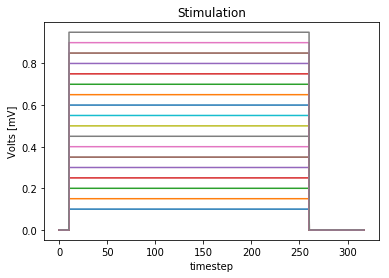

In [28]:
choose_work_dir()

In [34]:
run_all_stims()

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17


3168
3168
3168
3168
3168
3168
3168
3168
3168
3168
3168
3168
3168
3168
3168
3168
3168
3168


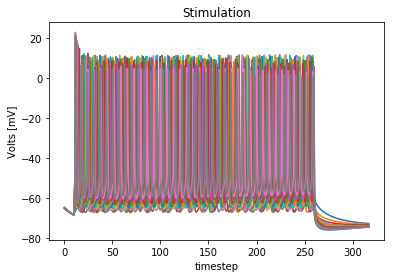

In [35]:
plot_all_volts()

53856


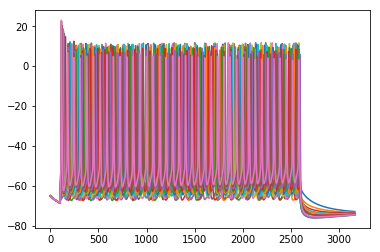

In [40]:
neuron_volts_fn = 'E:\Workspace\BBP_CC\Volts\orig_step_dNAC222_L5_ChC_75c658c9b8[0].soma[0].dat'
nrn_volts = nrnMreadFloat(neuron_volts_fn)
nrn_volts = nrn_volts.reshape(17,3168)
nstims = stims.shape[0]
np.savetxt(data_folder + 'NRNVolts.csv',nrn_volts,delimiter=',')
f, ax = plt.subplots(1)

ax.plot(nrn_volts.transpose())
plt.show()

(17, 3168)
(18, 3168)


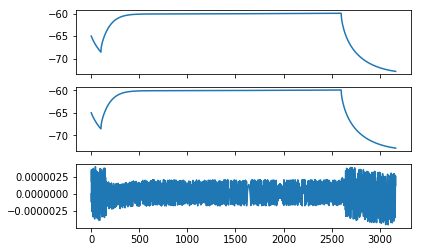

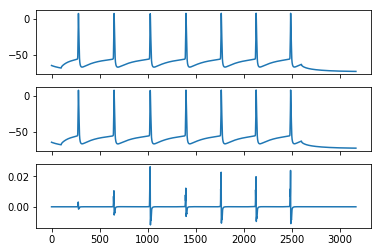

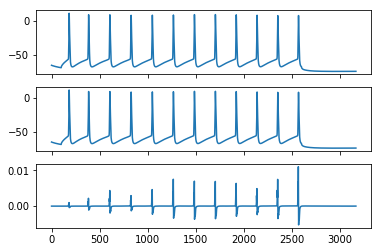

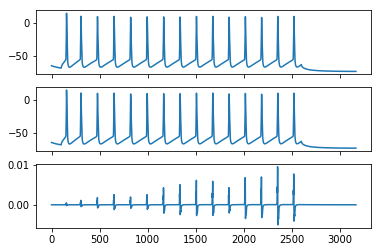

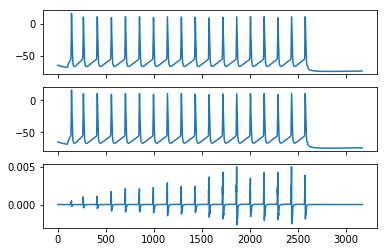

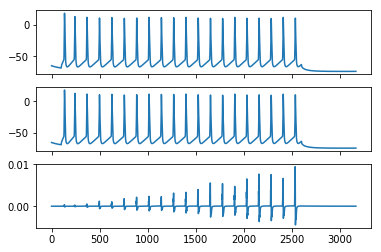

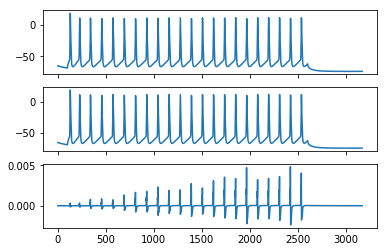

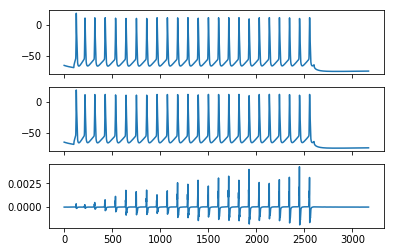

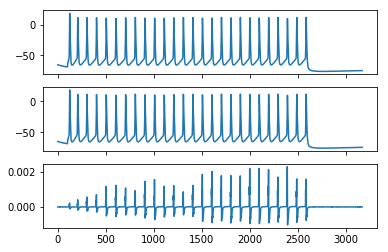

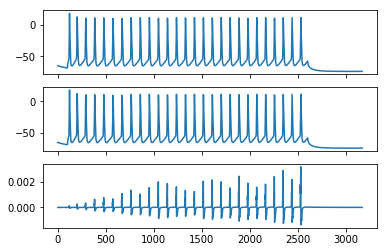

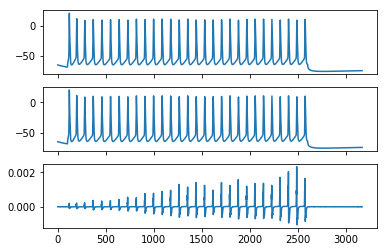

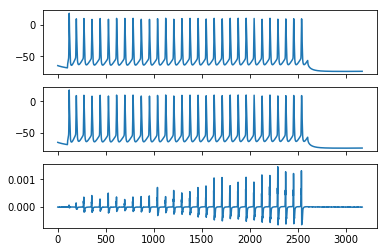

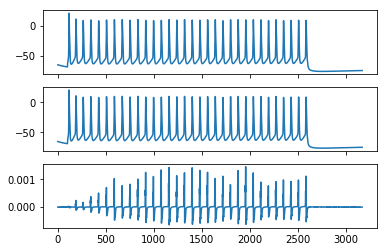

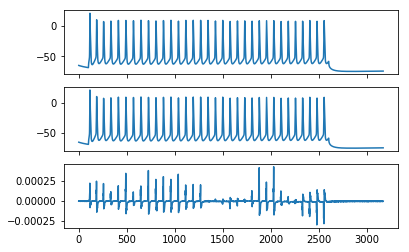

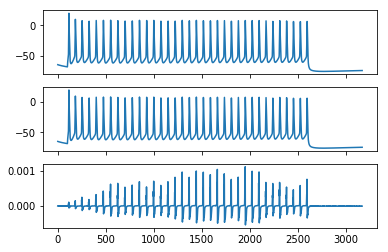

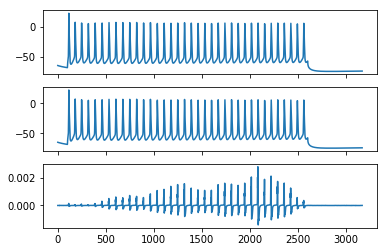

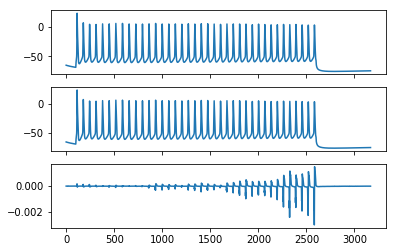

In [41]:
from scipy.signal import find_peaks
nstims = stims.shape[0]
nrn_volts = np.genfromtxt(data_folder + 'NRNVolts.csv', delimiter=',')
gpu_volts = np.genfromtxt(data_folder + 'AllVolts.csv', delimiter=',')

print(nrn_volts.shape)
print(gpu_volts.shape)
err = []
err_max = []
err_mean = []
npeaks = []
for curr_ind in range(nstims-1):
    f, axarr = plt.subplots(3, sharex=True)
    err.append(nrn_volts[curr_ind]-gpu_volts[curr_ind])
    axarr[0].plot(nrn_volts[curr_ind])
    axarr[1].plot(gpu_volts[curr_ind])
    axarr[2].plot(err[curr_ind])
    peaks, _ =find_peaks(nrn_volts[curr_ind],-10)
    npeaks.append(len(peaks))
    tmp = np.absolute(err[curr_ind])
    err_max.append(np.amax(tmp))
    err_mean.append(np.mean(tmp))
    plt.show()
err = np.array(err)
np.savetxt(data_folder + 'error.csv',err,delimiter=',')
    

In [42]:
print(err_mean)
print(err_max)
print(npeaks)

[1.1821286429713804e-06, 0.0003403906702993207, 0.00018405749198593274, 0.00018264417572345603, 0.0001375066967599213, 0.00019205183455238515, 0.00013523151021955737, 0.0001355756831538601, 8.9451166512492e-05, 0.00010621718743441584, 7.703400760603753e-05, 5.5346546933476795e-05, 7.885742434979248e-05, 1.7873093992540923e-05, 6.258104342125856e-05, 0.00010722539574839878, 7.261940604158552e-05]
[4.498466523727984e-06, 0.026428852452587748, 0.011040841888016573, 0.009557342553645043, 0.004992419983857133, 0.00938491808063091, 0.0048180513188604834, 0.004265031679864251, 0.002268136846383939, 0.0031595848066530152, 0.002322764353015927, 0.001454494689646424, 0.0014550906140797792, 0.00043006850041038547, 0.0011183679497346333, 0.002803063820630669, 0.003008519398981946]
[0, 7, 12, 15, 18, 20, 22, 24, 26, 27, 29, 30, 32, 33, 35, 36, 38]
